<a href="https://colab.research.google.com/github/samuel-haddad/MBAUSP/blob/main/xgboost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo XGBoost**

#### MBA Data Science & Analytics - USP & ESALQ
Trabalho de Conclusão de Curso - 02/2022 <br>
**Título:** Um estudo comparativo entre modelos Multinível, Logístico e XGBoost na detecção de fraudes ideológicas no setor financeiro. <br>
**Autor:** Samuel Haddad Simões Machado
<br>

## Bibliotecas

In [ ]:
# pacotes básicos
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# preprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# modelagem
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier

# google libs & auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Dataset

In [ ]:
link = 'https://drive.google.com/file/d/1U6RV2fdFHoqOyXmNbP6mFMEs23RfmGNG/view?usp=sharing'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('base_tcc_xgboost20220927.csv') 
 
df = pd.read_csv('base_tcc_xgboost20220927.csv', sep=';')
df.head()

,target,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var49,var50,var51,var52,var53,var54,var55,var56,var57,id
0,0,0.067438,1.079848,0,0,1,0,0,1,0,...,0,0,1,0,0,1,1,0,0,26
1,1,-0.100546,0.328359,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,128
2,0,0.417274,-0.553128,1,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,1,147
3,0,-0.266698,1.310873,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,174
4,1,0.379618,0.011451,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,186


## Treino, teste e validação

In [ ]:
# remover a coluna de id
df_silver = df.drop(['id'], axis=1)

# extrair as variáveis explicativas e resposta
X, y = df_silver.drop(['target'], axis=1), df_silver['target']

# separar a base de treino
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=42)
 
# separar as bases de teste e validação
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# distribuição da variável resposta nas bases
y_train_dist = y_train.sum()/len(y_train)
y_test_dist = y_test.sum()/len(y_test)
y_val_dist = y_val.sum()/len(y_val)

# exibir a volumetria das bases
print('+', 25*'-','RESUMO', 25*'-','+')
print(f'X_train: {X_train.shape} | y_train: {len(y_train)} \
        \nX_test:  {X_test.shape} | y_test: {len(y_test)} \
        \nX_val:   {X_val.shape} | y_val: {len(y_val)}'
        )
print(f'Train dist: {round(y_train_dist*100, 2)}% | Test dist: {round(y_test_dist*100, 2)}% | Val dist: {round(y_val_dist*100, 2)}%')
print('+', 58*'-', '+')

+ ------------------------- RESUMO ------------------------- +
X_train: (15860, 56) | y_train: 15860         
X_test:  (5287, 56) | y_test: 5287         
X_val:   (5287, 56) | y_val: 5287
Train dist: 35.5% | Test dist: 35.26% | Val dist: 34.82%
+ ---------------------------------------------------------- +


## Modelagem

In [ ]:
# construir o modelo com configuração padrão
model = XGBClassifier()

# treinar o modelo
model.fit(X_train, y_train)

# acurácia de treino
acuracy_train = model.score(X_train, y_train)


#---------- TESTE ----------#

# previsão - teste
y_pred_test = model.predict(X_test)

# extrair as métricas - test
acuracy_test = (metrics.accuracy_score(y_test, y_pred_test)*100).round(2)
precision_test = (metrics.precision_score(y_test, y_pred_test)*100).round(2)
recall_test = (metrics.recall_score(y_test, y_pred_test)*100).round(2)
aucroc_test = (roc_auc_score(y_test, model.predict_proba(X_test)[:,1])*100).round(2)
f1_score_test = (f1_score(y_test, y_pred_test)*100).round(2)
logloss_test = (metrics.log_loss(y_test, model.predict_proba(X_test), normalize=True))


##### VALIDAÇÃO #####

# construir o modelo com parâmetros otimizados
model = XGBClassifier(colsample_bytree=0.5317248496346453
                      ,learning_rate=0.12023450660570377
                      ,max_depth=6
                      ,min_child_weight=1
                      ,n_estimators=52
                      ,n_jobs=100
                      ,subsample=0.716121181244957
                      ,verbosity=0
                      ,random_state=982268122
                      )

# treinar o modelo
model.fit(X_train, y_train)

# previsão - teste
y_pred = model.predict(X_val)

# extrair as probabilidades
yhat = model.predict_proba(X_val)[:, 1]

# extrair as métricas - val
acuracy_val = (metrics.accuracy_score(y_val, y_pred)*100).round(2)
precision_val = (metrics.precision_score(y_val, y_pred)*100).round(2)
recall_val = (metrics.recall_score(y_val, y_pred)*100).round(2)
aucroc_val = (roc_auc_score(y_val, yhat)*100).round(2)
f1_score_val = (f1_score(y_val, y_pred)*100).round(2)
logloss_val = (metrics.log_loss(y_val, yhat, normalize=True))


# criar o dataframe comparativo
columns= ['amostra', 'acuracia', 'precisao', 'recall', 'auc_roc', 'f1_score', 'logloss(normalizada)']
data = [('teste', acuracy_test, precision_test, recall_test, aucroc_test, f1_score_test, logloss_test)
        ,('validacao', acuracy_val, precision_val, recall_val, aucroc_val, f1_score_val, logloss_val)
        ]
df_metrics = pd.DataFrame(data=data, columns=columns)

# visualizar tabela comparativa
df_metrics

,amostra,acuracia,precisao,recall,auc_roc,f1_score,logloss(normalizada)
0,teste,77.57,73.28,57.24,81.41,64.28,0.488186
1,validacao,78.14,74.38,56.76,82.33,64.39,0.477099


## Gráficos

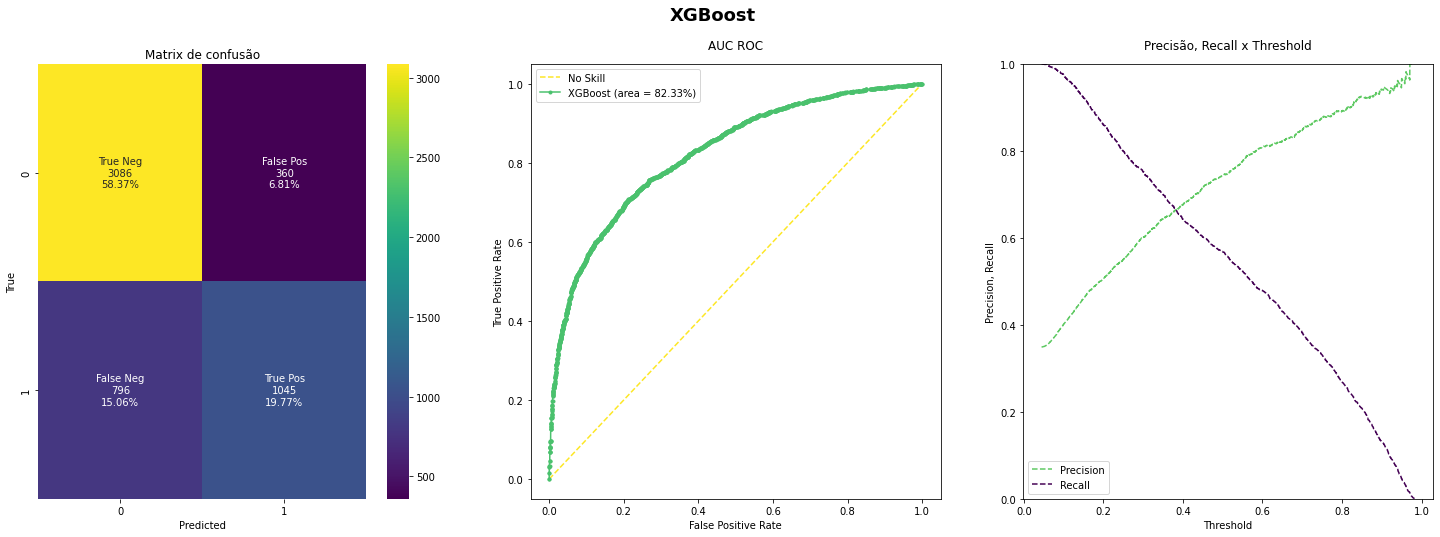

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), gridspec_kw=({'hspace':0.5}))
fig.suptitle('XGBoost', fontsize=18, weight='semibold', y=0.98)
pad = 15

#---------- matriz de confusão ----------#
cnf_matrix = confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 1)

labels = [0, 1]
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# criar o heatmap
ax = sns.heatmap(data=pd.DataFrame(cnf_matrix), annot=labels, cmap="viridis", fmt='')
ax.xaxis.set_label_position("bottom")
ax.set_title('Matrix de confusão')
plt.ylabel('True')
plt.xlabel('Predicted');

#---------- auc roc ----------#
fpr, tpr, thresholds = roc_curve(y_val, yhat)

# plot da curva roc
plt.subplot(1, 3, 2)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='XGBoost (area = {}%)'.format(aucroc_val))

# axis labels
plt.title('AUC ROC', pad=pad)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

#---------- precisão, recall x threshold ----------#
precision, recall, thresholds = precision_recall_curve(y_val, yhat) 

plt.subplot(1, 3, 3)
plt.title('Precisão, Recall x Threshold', fontsize=12, pad=pad)
plt.plot(thresholds, precision[: -1], "b--", label="Precision", color='#5ec962')
plt.plot(thresholds, recall[: -1], "r--", label="Recall", color='#440154')
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)


print('ROC AUC: {}% | Std dev: {}%'.format(round(np.mean(n_scores)*100,2), round(np.std(n_scores)*100, 2)))


ROC AUC: 82.47% | Std dev: 0.32%
